In [24]:
import _mypath
import os
import shutil
import cv2
import seaborn as sns
import pandas as pd

from database.data_path import build_data_paths 

In [2]:
# for local use
work_dir = '..'

In [3]:
image_size = 512
data_name = "data"
data_split_name = "data_split"

In [4]:
data_dir = os.path.join(work_dir, data_name)
grain_types = ["barley", "corn", "hard_wheat", "soft_wheat", "mix"]
devices = ["device1", "device2"]

data_paths = build_data_paths(data_dir, grain_types, devices)
print(data_paths)

(['../data/barley_device1', '../data/barley_device2', '../data/corn_device1', '../data/hard_wheat_device1', '../data/soft_wheat_device1', '../data/soft_wheat_device2', '../data/mix_device1'], [[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])


In [5]:
data_split_dir = os.path.join(work_dir, data_split_name)
if not os.path.exists(data_split_dir):
    os.makedirs(data_split_dir, exist_ok=True)


In [40]:
import cv2

def equalize_bright(img):
# convert from RGB color-space to YCrCb
    ycrcb_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # equalize the histogram of the Y channel
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])

    # convert back to RGB color-space from YCrCb
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

    return equalized_img

def equalize_bw(img):
# convert from RGB color-space to gray
    bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # equalize the histogram of the gray channel
    bw_img = cv2.equalizeHist(bw_img)

    # convert back to RGB color-space from YCrCb
    equalized_img = cv2.cvtColor(bw_img, cv2.COLOR_GRAY2BGR)

    return equalized_img

In [41]:
M = image_size
N = image_size
for path in data_paths:
    new_path = path.replace(data_name, data_split_name)
    if not os.path.exists(new_path):
        os.makedirs(new_path, exist_ok=True)

    files = [f for f in os.listdir(path) if f[-4:] == ".jpg"]
    for f in files:
        f_name = f[:-4]
        img = cv2.imread(os.path.join(path, f))
        img = equalize_bw(img)
        tiles = [img[x:x+M,y:y+N] for x in range(0,img.shape[0]-M,M) for y in range(0,img.shape[1]-N,N)]

        shape =  img.shape
        n_row = (shape[0] - M) // M
        n_col = (shape[1] - N) // N
        i = 0
        for r in range(n_row):
            for c in range(n_col):
                img = tiles[i]
                i += 1
                cv2.imwrite(os.path.join(new_path, f_name + "_" + str(r) + "_" + str(c) + ".jpg"), img)
            



In [15]:
height = []
width = []
rate = []
for path in data_paths:
    files = [f for f in os.listdir(path) if f[-4:] == ".jpg"]
    for f in files:
        img = cv2.imread(os.path.join(path, f))
        shape = img.shape
        height.append(shape[0])
        width.append(shape[1])
        rate.append(shape[1] / shape[0])


<Axes: ylabel='Count'>

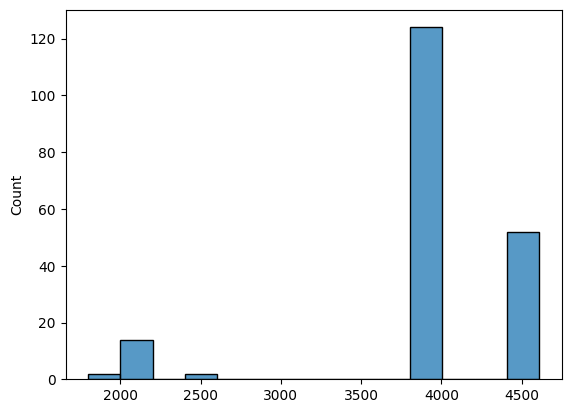

In [19]:
sns.histplot(height)


<Axes: ylabel='Count'>

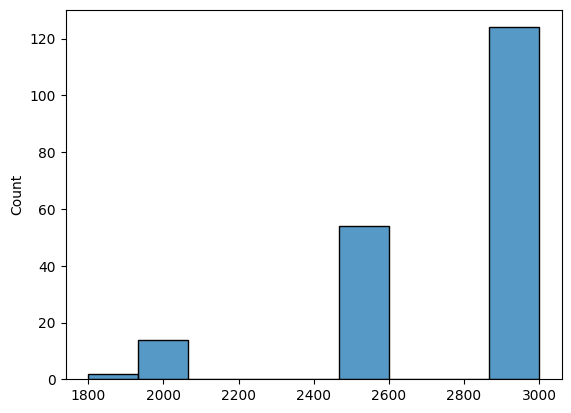

In [20]:
sns.histplot(width)


<Axes: ylabel='Count'>

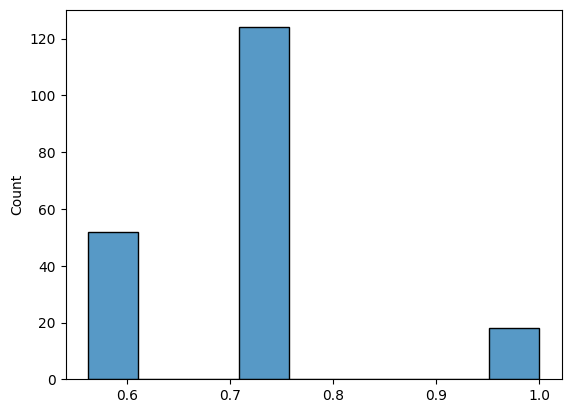

In [21]:
sns.histplot(rate)

In [17]:
data_split_dir = os.path.join(work_dir, data_split_name)
mix_types = ["mix"]
data_paths_mix, _ = build_data_paths(data_split_dir, mix_types, ["device1"])
print(data_paths_mix)

data_paths_mix = data_paths_mix[0]

df_mix_path = os.path.join(data_paths_mix, "labels.csv")
print(df_mix_path)
df_mix = pd.read_csv(df_mix_path, sep=';')
df_mix.head()

['../data_split/mix_device1']
../data_split/mix_device1/labels.csv


,image_id,specie_pct_label
0,84293a4a-3bf0-4496-a97e-db42affd1d6a,"{'barley': 92, 'soft_wheat': 8}"
1,da4deef4-b9cc-4616-851e-0dd8f6fabf13,"{'soft_wheat': 81, 'barley': 19}"
2,f6e2b462-8f1a-473a-8c9a-6750284b7de4,"{'barley': 77, 'soft_wheat': 23}"
3,babedc24-c2e7-4225-8e25-0968c81a646b,"{'barley': 77, 'soft_wheat': 23}"
4,33b22209-1890-415c-8919-7fd847506ac7,"{'soft_wheat': 94, 'barley': 6}"


In [27]:
import re

for image_id in df_mix['image_id']:
    image_id = image_id.strip()
    print(image_id)

    id_path = os.path.join(data_paths_mix, image_id)
    if not os.path.exists(id_path):
        os.makedirs(id_path, exist_ok=True)
    
    files = [f for f in os.listdir(data_paths_mix) if (re.match(image_id, f) and f[-4:] == ".jpg")]
    # print(files)

    full_file_name_in = [os.path.join(data_paths_mix, f) for f in files]
    full_file_name_out = [os.path.join(id_path, f) for f in files]

    for src, dest in zip(full_file_name_in, full_file_name_out):
        shutil.move(src, dest)


84293a4a-3bf0-4496-a97e-db42affd1d6a
da4deef4-b9cc-4616-851e-0dd8f6fabf13
f6e2b462-8f1a-473a-8c9a-6750284b7de4
babedc24-c2e7-4225-8e25-0968c81a646b
33b22209-1890-415c-8919-7fd847506ac7
27da3522-fc54-47e7-9025-9e77187d76af
b4eafb18-e6cf-45cb-b185-0db4f1eef9f2
75a205c9-36ad-4233-99e9-e2538212dad8
8c5a86c5-d015-48a5-9877-c8659bf3677a
65893dab-d585-4313-b75e-bec8c5cd1794
03e08cf4-faaf-4d97-8b54-a4c3905cae2e
63ecf334-1b39-48df-8a48-cf3047a9516d
abd06ff4-4ea1-4577-8627-7da841cc1f82
cba0538f-e52c-4053-801a-e2796c263969
55464dd4-c943-4fea-af03-86e87a0cf036
370d9b14-cbe5-4dc8-acf6-662df92448fa
eda51889-e378-4f95-991e-8cc2d064832c
b9995bae-af6a-4749-a9fa-10d8ce4395bb
